In [1]:
from pathlib import Path

from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
import sklearn.metrics as metrics

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

DATA = Path('../data/')

### Stationary(Median Imp) + Cases and Deaths

In [2]:
# Read different feature files
stationary_features = pd.read_csv(DATA/'processed/abridged_stationary_features_median_imputed.tsv', sep='\t')
# mobility_features = pd.read_csv(DATA/'processed/mobility_time_varying_features.tsv', sep='\t')
cases_deaths_features = pd.read_csv(DATA/'processed/abridged_time_varying_features.tsv', sep='\t')
# lockdown_features = pd.read_csv(DATA/'processed/abridged_time_based_features.tsv', sep='\t')

In [64]:
# Combine
all_features = cases_deaths_features.merge(stationary_features, on='countyFIPS', how='left')
# all_features = all_features.merge(lockdown_features, on='countyFIPS', how='left')
# all_features = all_features.merge(mobility_features, on=['countyFIPS', 'days_since_first_death'], how='left')

#### Predict Deaths in future

In [71]:
# Remove data points which haven't had at least 4 days since first death
num_tspoints = all_features.groupby('countyFIPS').agg({'days_since_first_death': lambda s: len(s)}).iloc[:, 0]
counties_to_remove = list(num_tspoints[num_tspoints < 3].index)
print(f"Data from {len(counties_to_remove)} counties will be removed.")
to_keep = ~all_features.countyFIPS.isin(counties_to_remove)
all_features = all_features[to_keep].reset_index(drop=True)

Data from 0 counties will be removed.


In [72]:
# Split into train and test set
all_features.sort_values(['countyFIPS', 'days_since_first_death'], inplace=True)
test_indices = [
    ind for indlst in 
    all_features.reset_index().groupby('countyFIPS').agg({'index': lambda s: list(s)[-4:]})['index']
    for ind in indlst]

# Data
X = all_features.drop(['deaths-0', 'cases-0'], axis=1)
y = all_features['deaths-0']

# Encode labels
le = preprocessing.LabelEncoder()
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = le.fit_transform(X[col])

# Test set
# For each county, keep the data for the last 4 observed days as test set
X_test = X.loc[test_indices].reset_index(drop=True)
y_test = y.loc[test_indices].reset_index(drop=True)

# Train set
X_train = X.drop(test_indices, axis=0).reset_index(drop=True)
y_train = y.drop(test_indices, axis=0).reset_index(drop=True)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((32654, 141), (32654,), (5724, 141), (5724,))

#### Baseline

In [90]:
rf = RandomForestRegressor(n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [98]:
X_test = X_test.drop_duplicates(['countyFIPS'], keep='last')
y_test = y_test.loc[X_test.index]

In [99]:
y_pred = rf.predict(X_test)

In [100]:
metrics.mean_squared_error(y_test, y_pred)

852567.536454717

In [101]:
metrics.mean_absolute_error(y_test, y_pred)

60.279028651292805

Text(0, 0.5, 'predicted')

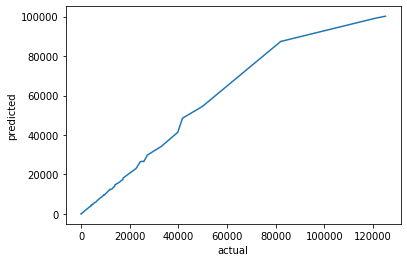

In [102]:
sns.lineplot(y_test, y_pred, )
plt.xlabel('actual')
plt.ylabel('predicted')

In [26]:
# Combine
all_features = cases_deaths_features.merge(stationary_features, on='countyFIPS', how='left')
# all_features = all_features.merge(lockdown_features, on='countyFIPS', how='left')
# all_features = all_features.merge(mobility_features, on=['countyFIPS', 'days_since_first_death'], how='left')

In [27]:
min_deaths = 10
log_min_deaths = np.log(min_deaths)

# Keep only those counties which have experienced a certain number of minimum deaths
countywise_log_max_deaths = all_features.groupby('countyFIPS').agg({'log_deaths-0': max})['log_deaths-0']
to_remove = list(countywise_log_max_deaths[countywise_log_max_deaths < log_min_deaths].index)
print(f"{len(to_remove)} counties will be removed.")
all_features = all_features.loc[~all_features.countyFIPS.isin(to_remove)]

58 counties will be removed.


In [14]:
num_tspoints = all_features.groupby('countyFIPS').agg({'days_since_first_death': lambda s: len(s)}).iloc[:, 0]

In [18]:
num_tspoints[num_tspoints == num_tspoints.min()]

countyFIPS
20057    1
31047    1
42081    1
45089    1
Name: days_since_first_death, dtype: int64

In [25]:
all_features.loc[all_features.countyFIPS == 20057]

,countyFIPS,log_deaths-0,log_cases-0,days_since_first_death,log_deaths-1,log_cases-1,log_deaths-2,log_cases-2,log_deaths-3,log_cases-3,...,MISSING_PopFmle>842010,MISSING_3-YrMortalityAge45-54Years2015-17,MISSING_3-YrMortalityAge55-64Years2015-17,MISSING_3-YrMortalityAge65-74Years2015-17,MISSING_3-YrMortalityAge75-84Years2015-17,MISSING_3-YrMortalityAge85+Years2015-17,MISSING_SVIPercentile,MISSING_HPSAShortage,MISSING_HPSAServedPop,MISSING_HPSAUnderservedPop
12873,20057,2.484907,8.490644,6,2.302585,8.291296,2.079442,8.045588,1.791759,7.735433,...,False,False,False,False,False,False,False,False,False,False


In [38]:




# Find number of data points for each county
num_tspoints = all_features.groupby('countyFIPS').agg({'days_since_first_death': lambda s: len(s)}).iloc[:, 0]

# 

# Remove counties which don't have at least num_days + 1 data points
to_remove = list(num_tspoints[num_tspoints < (num_days + 1)].index)


# Create a train-test split

# 1. County wise index of data points
all_features = all_features.sort_values(['countyFIPS', 'days_since_first_death']).reset_index(drop=True)
countywise_tsindex = all_features.reset_index().groupby('countyFIPS').agg({'index': list})['index'].to_dict()

In [4]:
all_features

,countyFIPS,log_deaths-0,log_cases-0,days_since_first_death,log_deaths-1,log_cases-1,log_deaths-2,log_cases-2,log_deaths-3,log_cases-3,...,MISSING_PopFmle>842010,MISSING_3-YrMortalityAge45-54Years2015-17,MISSING_3-YrMortalityAge55-64Years2015-17,MISSING_3-YrMortalityAge65-74Years2015-17,MISSING_3-YrMortalityAge75-84Years2015-17,MISSING_3-YrMortalityAge85+Years2015-17,MISSING_SVIPercentile,MISSING_HPSAShortage,MISSING_HPSAServedPop,MISSING_HPSAUnderservedPop
0,1001,1.791759,4.644391,6,1.609438,4.442651,1.386294,4.189655,1.098612,3.850148,...,False,False,False,False,False,False,False,True,True,True
1,1001,1.945910,4.844187,7,1.791759,4.644391,1.609438,4.442651,1.386294,4.189655,...,False,False,False,False,False,False,False,True,True,True
2,1001,2.079442,5.023881,8,1.945910,4.844187,1.791759,4.644391,1.609438,4.442651,...,False,False,False,False,False,False,False,True,True,True
3,1001,2.197225,5.176150,9,2.079442,5.023881,1.945910,4.844187,1.791759,4.644391,...,False,False,False,False,False,False,False,True,True,True
4,1001,2.302585,5.308268,10,2.197225,5.176150,2.079442,5.023881,1.945910,4.844187,...,False,False,False,False,False,False,False,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38499,2195,3.332205,4.317488,28,3.295837,4.262680,3.258097,4.204693,3.218876,4.143135,...,False,True,True,True,True,True,False,True,True,True
38500,2195,3.367296,4.369448,29,3.332205,4.317488,3.295837,4.262680,3.258097,4.204693,...,False,True,True,True,True,True,False,True,True,True
38501,2195,3.401197,4.418841,30,3.367296,4.369448,3.332205,4.317488,3.295837,4.262680,...,False,True,True,True,True,True,False,True,True,True
38502,2195,3.433987,4.465908,31,3.401197,4.418841,3.367296,4.369448,3.332205,4.317488,...,False,True,True,True,True,True,False,True,True,True


In [59]:
all_features[all_features['deaths-0'] == 0]

,countyFIPS,deaths-0,cases-0,days_since_first_death,deaths-1,cases-1,deaths-2,cases-2,deaths-3,cases-3,...,MISSING_PopFmle>842010,MISSING_3-YrMortalityAge45-54Years2015-17,MISSING_3-YrMortalityAge55-64Years2015-17,MISSING_3-YrMortalityAge65-74Years2015-17,MISSING_3-YrMortalityAge75-84Years2015-17,MISSING_3-YrMortalityAge85+Years2015-17,MISSING_SVIPercentile,MISSING_HPSAShortage,MISSING_HPSAServedPop,MISSING_HPSAUnderservedPop
132,1031,0,105,5,0,98,0,95,0,88,...,False,False,False,False,False,False,False,True,True,True
133,1031,0,107,6,0,105,0,98,0,95,...,False,False,False,False,False,False,False,True,True,True
134,1031,0,111,7,0,107,0,105,0,98,...,False,False,False,False,False,False,False,True,True,True
135,1031,0,117,8,0,111,0,107,0,105,...,False,False,False,False,False,False,False,True,True,True
136,1031,0,118,9,0,117,0,111,0,107,...,False,False,False,False,False,False,False,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37327,54055,0,10,46,0,10,0,10,0,10,...,False,False,False,False,False,False,False,False,False,False
37328,54055,0,10,47,0,10,0,10,0,10,...,False,False,False,False,False,False,False,False,False,False
37329,54055,0,11,48,0,10,0,10,0,10,...,False,False,False,False,False,False,False,False,False,False
37330,54055,0,11,49,0,11,0,10,0,10,...,False,False,False,False,False,False,False,False,False,False


In [57]:
tsspl = TimeSeriesSplit(n_splits=2)
for trn, tst in tsspl.split(countywise_tsindex[6085]): 
    print(trn)
    print(tst)
    print('\n')

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
[30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57]


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57]
[58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81
 82 83 84 85]




In [48]:
tst

array([72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85])

In [46]:
tst

array([16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [18]:
num_tspoints.sort_values()

countyFIPS
33009     1
42081     1
21157     1
17001     1
39123     1
         ..
12113    57
6061     59
53061    61
53033    63
6085     86
Name: days_since_first_death, Length: 1487, dtype: int64

In [20]:
all_features[all_features.countyFIPS == 39123]

,countyFIPS,deaths-0,cases-0,days_since_first_death,deaths-1,cases-1,deaths-2,cases-2,deaths-3,cases-3,...,MISSING_PopFmle>842010,MISSING_3-YrMortalityAge45-54Years2015-17,MISSING_3-YrMortalityAge55-64Years2015-17,MISSING_3-YrMortalityAge65-74Years2015-17,MISSING_3-YrMortalityAge75-84Years2015-17,MISSING_3-YrMortalityAge85+Years2015-17,MISSING_SVIPercentile,MISSING_HPSAShortage,MISSING_HPSAServedPop,MISSING_HPSAUnderservedPop
27476,39123,2,44,5,1,44,1,40,1,40,...,False,False,False,False,False,False,False,True,True,True


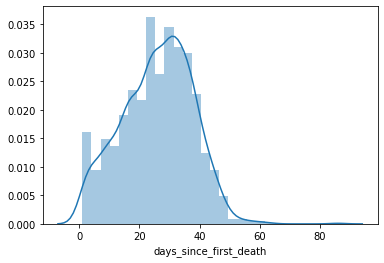

In [10]:
sns.distplot(num_tspoints)

In [1]:
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
# Remove data points which haven't had at least 4 days since first death
num_tspoints = all_features.groupby('countyFIPS').agg({'days_since_first_death': lambda s: len(s)}).iloc[:, 0]
counties_to_remove = list(num_tspoints[num_tspoints < 4].index)
print(f"Data from {len(counties_to_remove)} counties will be removed.")
to_keep = ~all_features.countyFIPS.isin(counties_to_remove)
all_features = all_features[to_keep].reset_index(drop=True)